# Modeling Optimal Poker Policy as an MDP


In [ ]:
from typing import Dict, List, Set, Tuple, Any, Callable
import collections
import itertools
import random
import math

## Define the Problem as an MDP
We can define this simple poker hand optimization problem as an MDP where the state is represented by the cards in your hand / on the table.

Abstract MDP class interface

In [ ]:
# An abstract class representing a Markov Decision Process (MDP).
class MDP:
    # Return the start state.
    def startState(self) -> Tuple: raise NotImplementedError("Override me")

    # Return set of actions possible from |state|.
    def actions(self, state: Tuple) -> List[Any]: raise NotImplementedError("Override me")

    # Return a list of (newState, prob, reward) tuples corresponding to edges
    # coming out of |state|.
    # Mapping to notation from class:
    #   state = s, action = a, newState = s', prob = T(s, a, s'), reward = Reward(s, a, s')
    # If IsEnd(state), return the empty list.
    def succAndProbReward(self, state: Tuple, action: Any) -> List[Tuple]: raise NotImplementedError("Override me")

    def discount(self): raise NotImplementedError("Override me")

    # Compute set of states reachable from startState.  Helper function for
    # MDPAlgorithms to know which states to compute values and policies for.
    # This function sets |self.states| to be the set of all states.
    def computeStates(self):
        self.states = set()
        queue = []
        self.states.add(self.startState())
        queue.append(self.startState())
        while len(queue) > 0:
            state = queue.pop()
            for action in self.actions(state):
                for newState, prob, reward in self.succAndProbReward(state, action):
                    if newState not in self.states:
                        self.states.add(newState)
                        queue.append(newState)
        if len(self.states) < 100:
            print("All States")
            for state in self.states:
              print(state)
        else:
            print("Num total states", len(self.states))

Poker MDP Implementation

In [ ]:
class PokerMDP(MDP):
    def __init__(self, cardValues: List[int], multiplicity: int, numInHand=5, numToDrop=3, numRounds=1):
        """
        cardValues: list of integers (face values for each card included in the deck)
        multiplicity: single integer representing the number of cards with each face value
        numInHand: number of cards to hold in hand, standard poker is 5
        numToDrop: max number of cards that can be dropped and replaced, standard poker is 3
        numRounds: number of rounds to play before revealing cards, standard poker is 1
        """
        if numInHand < 5:
            print("Warning: numInHand must be >= 5")
        if numToDrop > numInHand:
            print("Warning: numToDrop must be <= numInHand")
        if cardValues != sorted(cardValues):
            print("Warning: cardValues should be sorted")

        self.cardValues = cardValues
        self.multiplicity = multiplicity
        self.numInHand = numInHand
        self.numToDrop = numToDrop
        self.numRounds = numRounds
        self._discount = 1

    # Each state is a tuple with 3 elements:
    #   -- The first element is a tuple of cardValues in hand or None if the game is over
    #   -- The second element is a tuple of cardValues left in the deck or None if the deck is empty
    #   -- The third element is the round number, starting from 0.
    def startState(self) -> Tuple:
        deck = []
        for card in self.cardValues:
            deck += [(card, i) for i in range(self.multiplicity)]
        return (tuple([None] * self.numInHand), tuple(deck), 0)

    # Return list of actions possible from |state|.
    # If the round == 0: return [+ | numInHand |].
    # Otherwise: return [-0 ... -numToDrop]
    def actions(self, state: Tuple or None) -> List[Set[int]]:
        # return None if state is None (aka game is over) or we're on the first round (only 1 action, must be dealt cards)
        if state == None or state[2] == 0:
            return [None]
        all_actions = []
        for i in range(self.numToDrop + 1):
            all_actions += [tuple(sorted(x)) for x in itertools.combinations(list(state[0]), i)]
        return list(set(all_actions))

    # The MDP currently does not track the suits of the cards, so we will ignore the 
    # Straight Flush and Flush combinations. Additionally, the Full House and Two Pair
    # combinations will only be evaluated by the value of the "top" card 
    # Ex: in an MDP with cardValues = [1, 2, 3, 4, 5]
    # reward([1, 1, 3, 3, 3]) == reward([3, 3, 3, 5, 5]) == 5 * 5 + 2 = 27
    # reward([2, 2, 3, 3, 5]) == reward([1, 1, 3, 3, 5]) == 2 * 5 + 2 = 12
    def evaluateHand(self, hand: List[int]) -> int:
        if self.numInHand != 5:
            print("Warning: evaluating hand on 5 cards. If numInHand != 5, may not be accurate.")

        combos = ["High Card", "Pair", "Two Pair", "Three of a Kind", "Straight", "Flush", "Full House", "Four of a Kind", "Straight Flush", "Five of a Kind", "Royal Flush"]
        counts = {}
        isStraight = True
        isFlush = True
        prevCard = None
        for card in hand:
            counts[card] = counts.get(card, 0) + 1
            isStraight = isStraight and (prevCard is None or card[0] == prevCard[0] + 1)
            isFlush = isFlush and card[1] == hand[0][1]
            prevCard = card

        maxCount, maxCardIndex, numPairs = 0, None, 0
        for card in sorted(counts.keys(), reverse=True):
            count = counts[card]
            if count == 2:
                numPairs += 1
            if count > maxCount:
                maxCount = count
                maxCardIndex = self.cardValues.index(card[0])
        
        numCardValues = len(self.cardValues)
        if isFlush and isStraight and maxCardIndex == numCardValues - 1:
            return combos.index("Royal Flush") * numCardValues
        elif maxCount >= 4:
            return combos.index("Four of a Kind" if maxCount == 4 else "Five of a Kind") * numCardValues + maxCardIndex
        elif isFlush and isStraight:
            return combos.index("Straight Flush") * numCardValues + maxCardIndex
        elif maxCount == 3:
            return combos.index("Full House" if numPairs >= 1 else "Three of a Kind") * numCardValues + maxCardIndex
        elif isStraight or isFlush:
            return combos.index("Straight" if isStraight else "Flush") * numCardValues + maxCardIndex
        elif maxCount == 2:
            return combos.index("Two Pair" if numPairs == 2 else "Pair") * numCardValues + maxCardIndex
        elif maxCount == 1:
            return combos.index("High Card") * numCardValues + maxCardIndex
        else:
            print("Warning: invalid hand:", hand)
            return None

    # Given a |state| and |action|, return a list of (newState, prob, reward) tuples
    # corresponding to the states reachable from |state| when taking |action|.
    def succAndProbReward(self, state: Tuple, action: Set[int]) -> List[Tuple]:
        if state is None:
            return []
        hand, deck, round = state
        hand = list(hand)
        deck = list(deck)
        # end state, no more successors
        if hand == None or deck == None or round > self.numRounds: 
            return []
        if round == 0 and action == None:
            succs = []
            possibleDraws = [tuple(sorted(x)) for x in itertools.combinations(deck, self.numInHand)]
            for draw in possibleDraws:
                new_deck = deck.copy()
                for card in draw:
                    new_deck.remove(card)
                succs += [((draw, tuple(new_deck), round + 1), 1 / len(possibleDraws), 0)]
            return succs
        elif round == self.numRounds: # last round
            for cardToDrop in action:
                hand.remove(cardToDrop)
            succs = []
            replacements = list(itertools.combinations(deck, len(action)))
            repCounts = {} 
            for replacementSet in replacements:
                new_deck = deck.copy()
                for card in replacementSet:
                    new_deck.remove(card)
                new_hand = sorted(hand + list(replacementSet))
                succs += [((tuple(new_hand), tuple(new_deck), round + 1), 1 / len(replacements), self.evaluateHand(new_hand))]
            return succs
        else:
            for cardToDrop in action:
                hand.remove(cardToDrop)
            succs = []
            replacements = list(itertools.combinations(deck, len(action)))
            repCounts = {} 
            for replacementSet in replacements:
                new_deck = deck.copy()
                for card in replacementSet:
                    new_deck.remove(card)
                new_hand = sorted(hand + list(replacementSet))
                succs += [((tuple(new_hand), tuple(new_deck), round + 1), 1 / len(replacements), 0)]
            return succs

    def discount(self):
        return self._discount
      
    def setDiscount(self, discount: int):
        self._discount = discount


In [ ]:
## Michelle's MDP testing code
pokerMDP = PokerMDP([1, 2, 3, 4, 5], 3, numRounds=3)

## test rewards (not accurate anymore with addition of suits/flushes)
# print(pokerMDP.evaluateHand([1, 1, 1, 1, 1])) # expect 7 * 5 + 0 = 35
# print(pokerMDP.evaluateHand([2, 2, 2, 2, 2])) # expect 7 * 5 + 1 = 36
# print(pokerMDP.evaluateHand([3, 3, 3, 3, 3])) # expect 7 * 5 + 2 = 37
# print(pokerMDP.evaluateHand([4, 4, 4, 4, 4])) # expect 7 * 5 + 3 = 38
# print(pokerMDP.evaluateHand([5, 5, 5, 5, 5])) # expect 7 * 5 + 4 = 39

# print(pokerMDP.evaluateHand([1, 1, 1, 1, 2])) # expect 6 * 5 + 0 = 30
# print(pokerMDP.evaluateHand([1, 1, 1, 2, 2])) # expect 5 * 5 + 0 = 25
# print(pokerMDP.evaluateHand([1, 2, 3, 4, 5])) # expect 4 * 5 + 4 = 24
# print(pokerMDP.evaluateHand([1, 1, 1, 2, 3])) # expect 3 * 5 + 0 = 15
# print(pokerMDP.evaluateHand([1, 1, 2, 2, 3])) # expect 2 * 5 + 1 = 11
# print(pokerMDP.evaluateHand([1, 1, 2, 3, 4])) # expect 1 * 5 + 0 = 5

## test entire flow
# startState = pokerMDP.startState()
# print("Start state:", startState)
# actions = pokerMDP.actions(startState)
# print("Actions:", actions)
# a = actions[random.randint(0, len(actions) - 1)]
# print("Take action:", a)
# succs = pokerMDP.succAndProbReward(startState, a)
# randomSucc = succs[random.randint(0, len(succs) - 1)]
# print("Take successor:", randomSucc)
# newState = randomSucc[0]
# print("New State:", newState)
# actions = pokerMDP.actions(newState)
# print("Actions:", actions)
# a = actions[random.randint(0, len(actions) - 1)]
# print("Take action:", a)
# succs = pokerMDP.succAndProbReward(newState, a)
# print("Successors:", succs)
# randomSucc = succs[random.randint(0, len(succs) - 1)]
# print("Take successor:", randomSucc)
# newState = randomSucc[0]
# print("New State:", newState)
# actions = pokerMDP.actions(newState)
# print("Actions:", actions)
# a = actions[random.randint(0, len(actions) - 1)]
# print("Take action:", a)
# succs = pokerMDP.succAndProbReward(newState, a)
# print("Successors:", succs)
# randomSucc = succs[random.randint(0, len(succs) - 1)]
# print("Take successor:", randomSucc)

Start state: ((None, None, None, None, None), ((1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2)), 0)
Actions: [None]
Take action: None
Take successor: ((((1, 1), (3, 0), (4, 1), (5, 0), (5, 1)), ((1, 0), (1, 2), (2, 0), (2, 1), (2, 2), (3, 1), (3, 2), (4, 0), (4, 2), (5, 2)), 1), 0.000333000333000333, 0)
New State: (((1, 1), (3, 0), (4, 1), (5, 0), (5, 1)), ((1, 0), (1, 2), (2, 0), (2, 1), (2, 2), (3, 1), (3, 2), (4, 0), (4, 2), (5, 2)), 1)
Actions: [((5, 0), (5, 1)), ((3, 0), (5, 0)), ((1, 1),), ((1, 1), (5, 0), (5, 1)), ((3, 0), (4, 1), (5, 0)), ((1, 1), (4, 1), (5, 1)), ((4, 1), (5, 1)), ((3, 0), (4, 1), (5, 1)), ((3, 0), (5, 0), (5, 1)), ((3, 0), (4, 1)), ((1, 1), (3, 0), (4, 1)), ((1, 1), (3, 0), (5, 1)), ((1, 1), (4, 1), (5, 0)), ((3, 0), (5, 1)), ((1, 1), (4, 1)), ((1, 1), (3, 0)), ((4, 1),), ((3, 0),), ((4, 1), (5, 0)), ((5, 1),), ((4, 1), (5, 0), (5, 1)), ((5, 0),), ((1, 1), (5, 0)), ((1, 1), (3, 0), (5, 0))

## MDP Solving Algorithms
Algorithms that solve MDPs directly without simulations:
* Value Iteration
* Policy Iteration

In [ ]:
class MDPAlgorithm:
    # Set:
    # - self.pi: optimal policy (mapping from state to action)
    # - self.V: values (mapping from state to best values)
    def solve(self, mdp: MDP): raise NotImplementedError("Override me")

### Value Iteration

In [ ]:
class ValueIteration(MDPAlgorithm):
    '''
    Solve the MDP using value iteration.  Your solve() method must set
    - self.V to the dictionary mapping states to optimal values
    - self.pi to the dictionary mapping states to an optimal action
    Note: epsilon is the error tolerance: you should stop value iteration when
    all of the values change by less than epsilon.
    The ValueIteration class is a subclass of util.MDPAlgorithm (see util.py).
    '''
    def solve(self, mdp: MDP, epsilon=0.001):
        mdp.computeStates()
        def computeQ(mdp: MDP, V: Dict[Tuple, float], state: Tuple, action: Any) -> float:
            # Return Q(state, action) based on V(state).
            return sum(prob * (reward + mdp.discount() * V[newState]) for newState, prob, reward in mdp.succAndProbReward(state, action))

        def computeOptimalPolicy(mdp: MDP, V: Dict[Tuple, float]) -> Dict[Tuple, Any]:
            # Return the optimal policy given the values V.
            pi = {}
            for state in mdp.states:
                pi[state] = max((computeQ(mdp, V, state, action), action) for action in mdp.actions(state))[1]
            return pi

        V = collections.defaultdict(float)  # state -> value of state
        value_changes = {}
        for state in mdp.states:
          value_changes.setdefault(state, [])
        
        final_state = None
        numIters = 0
        while True:
            newV = {}
            for state in mdp.states:
                # This evaluates to zero for end states, which have no available actions (by definition)
                newV[state] = max(computeQ(mdp, V, state, action) for action in mdp.actions(state))
                value_changes[state].append(newV[state])
            numIters += 1

            max_diff = 0
            for state in mdp.states:
              new_max = abs(V[state] - newV[state])
              is_non_terminal_round = state[2] > 0
              if new_max > max_diff and is_non_terminal_round:
                max_diff = new_max
                final_state = state
            
            diff = max(abs(V[state] - newV[state]) for state in mdp.states)
            if diff < epsilon:
                V = newV
                break
            V = newV

        # Compute the optimal policy now
        pi = computeOptimalPolicy(mdp, V)
        print(("ValueIteration: %d iterations" % numIters))
        self.pi = pi
        self.V = V
        self.value_changes = value_changes
        self.final_state = final_state

### Policy Iteration

In [ ]:
class PolicyIteration(MDPAlgorithm):
    '''
    Solve the MDP using policy iteration.  Your solve() method must set
    - self.V to the dictionary mapping states to optimal values
    - self.pi to the dictionary mapping states to an optimal action
    Note: epsilon is the error tolerance: you should stop value iteration when
    all of the values change by less than epsilon.
    The PolicyIteration class is a subclass of util.MDPAlgorithm (see util.py).
    '''
    def solve(self, mdp: MDP):
        # TODO: Missing epsilon parameter?

        mdp.computeStates()

        def policyEvaluation(mdp: MDP, V: Dict[Tuple, float], pi: Dict[Tuple, Any])  -> Dict[Tuple, float]:
            #pi = {}
            #randomly initialize policy.
            #random.choice(list(d.values())) 
            #initialize policy
            k_max = 100

            
            for k in range(k_max):
                for state in mdp.states:
                    V[state] = computeQ(mdp, V, state, pi[state])
            
            return V
        
        def policyImprovement(mdp: MDP, V: Dict[Tuple, float]) -> Dict[Tuple, Any]:
            #improve the policy given values V from policy Evaluation
            pi = {}

            for state in mdp.states:
                pi[state] = max((computeQ(mdp, V, state, action), action) for action in mdp.actions(state))[1]
            return pi



        
        def computeQ(mdp: MDP, V: Dict[Tuple, float], state: Tuple, action: Any) -> float:
            # Return Q(state, action) based on V(state).
            return sum(prob * (reward + mdp.discount() * V[newState]) \
                            for newState, prob, reward in mdp.succAndProbReward(state, action))
        
        V = collections.defaultdict(float)
        value_changes = {}
        pi = {} 
        for state in mdp.states:
            value_changes.setdefault(state, [0])
            pi[state] = random.choice(mdp.actions(state))

        numIters = 0
        while True:
            V = policyEvaluation(mdp, V, pi)
            newpi = policyImprovement(mdp, V)
            numIters += 1
            
            all_equal = True
            for state in mdp.states:
              value_changes[state].append(V[state])
              if pi[state] != newpi[state]:
                all_equal = False
            
            if all_equal:
                pi = newpi
                break
            pi = newpi

        
        print(("PolicyIteration: %d iterations" % numIters))
        self.pi = pi
        self.V = V
        self.value_changes = value_changes


## Reinforcement Learning Algorithms

Algorithms that learn the optimal policy from simulations / rollouts:
* Q-Learning
* SARSA


In [ ]:
# Abstract class: an RLAlgorithm performs reinforcement learning.  All it needs
# to know is the set of available actions to take.  The simulator (see
# simulate()) will call getAction() to get an action, perform the action, and
# then provide feedback (via incorporateFeedback()) to the RL algorithm, so it can adjust
# its parameters.
class RLAlgorithm:
    # Your algorithm will be asked to produce an action given a state.
    def getAction(self, state: Tuple) -> Any: raise NotImplementedError("Override me")

    # We will call this function when simulating an MDP, and you should update
    # parameters.
    # If |state| is a terminal state, this function will be called with (s, a,
    # 0, None). When this function is called, it indicates that taking action
    # |action| in state |state| resulted in reward |reward| and a transition to state
    # |newState|.
    def incorporateFeedback(self, state: Tuple, action: Any, reward: int, newState: Tuple): raise NotImplementedError("Override me")

In [ ]:
# An RL algorithm that acts according to a fixed policy |pi| and doesn't
# actually do any learning.
class FixedRLAlgorithm(RLAlgorithm):
    def __init__(self, pi: Dict[Tuple, Any]): self.pi = pi

    # Just return the action given by the policy.
    def getAction(self, state: Tuple) -> Any: return self.pi[state]

    # Don't do anything: just stare off into space.
    def incorporateFeedback(self, state: Tuple, action: Any, reward: int, newState: Tuple): pass

### Q-Learning

In [ ]:
# Performs Q-learning.  Read util.RLAlgorithm for more information.
# actions: a function that takes a state and returns a list of actions.
# discount: a number between 0 and 1, which determines the discount factor
# featureExtractor: a function that takes a state and action and returns a list of (feature name, feature value) pairs.
# explorationProb: the epsilon value indicating how frequently the policy
# returns a random action
class QLearningAlgorithm(RLAlgorithm):
    def __init__(self, actions: Callable, discount: float, featureExtractor: Callable, explorationProb=0.2):
        self.actions = actions
        self.discount = discount
        self.featureExtractor = featureExtractor
        self.explorationProb = explorationProb
        self.weights = collections.defaultdict(float)
        self.numIters = 0

    # Return the Q function associated with the weights and features
    def getQ(self, state: Tuple, action: Any) -> float:
        # print("State to get Q from:", str(state))
        score = 0
        for f, v in self.featureExtractor(state, action):
            score += self.weights[f] * v
        return score

    # This algorithm will produce an action given a state.
    # Here we use the epsilon-greedy algorithm: with probability
    # |explorationProb|, take a random action.
    def getAction(self, state: Tuple) -> Any:
        self.numIters += 1
        if random.random() < self.explorationProb:
            return random.choice(self.actions(state))
        else:
            return max((self.getQ(state, action), action) for action in self.actions(state))[1]

    # Call this function to get the step size to update the weights.
    def getStepSize(self) -> float:
        return 1.0 / math.sqrt(self.numIters)

    # We will call this function with (s, a, r, s'), which you should use to update |weights|.
    # Note that if s is a terminal state, then s' will be None.  Remember to check for this.
    # You should update the weights using self.getStepSize(); use
    # self.getQ() to compute the current estimate of the parameters.
    def incorporateFeedback(self, state: Tuple, action: Any, reward: int, newState: Tuple) -> None:
        prediction = self.getQ(state, action)
        v_opt = 0 if newState is None else max(self.getQ(newState, next_action) for next_action in self.actions(newState))
        target = reward + self.discount * v_opt
        for f_key, f_value in self.featureExtractor(state, action):
            self.weights[f_key] = self.weights[f_key] - self.getStepSize() * (prediction - target) * f_value


### SARSA

In [ ]:
class SARSA(RLAlgorithm):
    def __init__(self, actions: Callable, discount: float, featureExtractor: Callable, explorationProb=0.2):
        self.actions = actions
        self.discount = discount
        self.featureExtractor = featureExtractor
        self.explorationProb = explorationProb
        self.weights = collections.defaultdict(float)
        self.numIters = 0

    def getQ(self, state: Tuple, action: Any) -> float:
        # print("State to get Q from:", str(state))
        score = 0
        for f, v in self.featureExtractor(state, action):
            score += self.weights[f] * v
        return score

    def getAction(self, state: Tuple) -> Any:
        self.numIters += 1
        if random.random() < self.explorationProb:
            return random.choice(self.actions(state))
        else:
            return max((self.getQ(state, action), action) for action in self.actions(state))[1]

    def getStepSize(self) -> float:
        return 1.0 / math.sqrt(self.numIters)

    def incorporateFeedback(self, state: Tuple, action: Any, reward: int, newState: Tuple) -> None:
        prediction = self.getQ(state, action)
        newAction = self.getAction(newState)

        v_opt = 0 if newState is None else self.getQ(newState, newAction)

        target = reward + self.discount * v_opt
        for f_key, f_value in self.featureExtractor(state, action):
            self.weights[f_key] = self.weights[f_key] - self.getStepSize() * (prediction - target) * f_value

        

### Feature Extractors

In [ ]:
# Return a single-element list containing a binary (indicator) feature
# for the existence of the (state, action) pair.  Provides no generalization.
def identityFeatureExtractor(state: Tuple, action: Any) -> List[Tuple[Tuple, int]]:
    featureKey = (state, action)
    featureValue = 1
    return [(featureKey, featureValue)]

## Simulation Function

In [ ]:
# Perform |numTrials| of the following:
# On each trial, take the MDP |mdp| and an RLAlgorithm |rl| and simulates the
# RL algorithm according to the dynamics of the MDP.
# Each trial will run for at most |maxIterations|.
# Return the list of rewards that we get for each trial.
def simulate(mdp: MDP, rl: RLAlgorithm, numTrials=10, maxIterations=1000, verbose=False,
             sort=False):
    # Return i in [0, ..., len(probs)-1] with probability probs[i].
    def sample(probs):
        target = random.random()
        accum = 0
        for i, prob in enumerate(probs):
            accum += prob
            if accum >= target: return i
        raise Exception("Invalid probs: %s" % probs)

    totalRewards = []  # The rewards we get on each trial
    for trial in range(numTrials):
        state = mdp.startState()
        sequence = [state]
        totalDiscount = 1
        totalReward = 0
        for _ in range(maxIterations):
            action = rl.getAction(state)
            transitions = mdp.succAndProbReward(state, action)
            if sort: transitions = sorted(transitions)
            if len(transitions) == 0:
                rl.incorporateFeedback(state, action, 0, None)
                break

            # Choose a random transition
            i = sample([prob for newState, prob, reward in transitions])
            newState, prob, reward = transitions[i]
            sequence.append(action)
            sequence.append(reward)
            sequence.append(newState)

            rl.incorporateFeedback(state, action, reward, newState)
            totalReward += totalDiscount * reward
            totalDiscount *= mdp.discount()
            state = newState
        if verbose:
            print(("Trial %d (totalReward = %s): %s" % (trial, totalReward, sequence)))
        totalRewards.append(totalReward)
    return totalRewards

## Let's run it all together!

### Testing Functions

In [ ]:
# Return whether two answers are equal.
def is_equal(true_answer, pred_answer, tolerance=1e-4):
    # Handle floats specially
    if isinstance(true_answer, float) or isinstance(pred_answer, float):
        return abs(true_answer - pred_answer) < tolerance
    # Recurse on collections to deal with floats inside them
    if is_collection(true_answer) and is_collection(pred_answer) and len(true_answer) == len(pred_answer):
        for a, b in zip(true_answer, pred_answer):
            if not is_equal(a, b):
                return False
        return True
    if isinstance(true_answer, dict) and isinstance(pred_answer, dict):
        if len(true_answer) != len(pred_answer):
            return False
        for k, v in list(true_answer.items()):
            if not is_equal(pred_answer.get(k), v):
                return False
        return True

    # Numpy array comparison
    if type(true_answer).__name__ == 'ndarray':
        import numpy as np
        if isinstance(true_answer, np.ndarray) and isinstance(pred_answer, np.ndarray):
            if true_answer.shape != pred_answer.shape:
                return False
            for a, b in zip(true_answer, pred_answer):
                if not is_equal(a, b):
                    return False
            return True

    # Do normal comparison
    return true_answer == pred_answer

def require_is_equal(true_answer, pred_answer, tolerance=1e-4):
    if not is_equal(true_answer, pred_answer, tolerance):
        print("Expected:", pred_answer, "Got:", true_answer)

### Testing Code

In [ ]:
mdp = PokerMDP([1, 2, 3, 4, 5], 3)
alg = ValueIteration()
alg.solve(mdp, .0001)

# alg = PolicyIteration()
# alg.solve(mdp)

# print states + optimal policies for sanity check
for state in alg.pi:
    if state[2] <= mdp.numRounds: # only print non-terminal states
        print("state", state, "policy", alg.pi[state])

## Tuning Hyperparameters & Plotting

MDP Algorithms: Value Iteration & Policy Iteration
* Learning rate, alpha

RL Algorithms: Q-Learning, SARSA
* Learning rate, alpha
* Discount factor, gamma

### Evaluation Metrics
* Runtime of algorithm
* Variation of Q-values and U-values

q_rl_rewards [1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.2, 1.7999999999999998, 1.2, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.2, 1.2, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.2, 1.7999999999999998, 1.7999999999999998, 1.2, 0.6, 1.7999999999999998, 1.7999999999999998, 1.2, 1.7999999999999998, 1.2, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.2, 1.7999999999999998, 1.2, 1.2, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.2, 1.2, 1.2, 1.7999999999999998, 1.2, 1.7999999999999998, 1.2, 1.7999999999999998, 1.2, 1.2, 1.2, 1.7999999999999998, 1.2, 1.2, 1.2, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.7999999999999998, 1.799999999

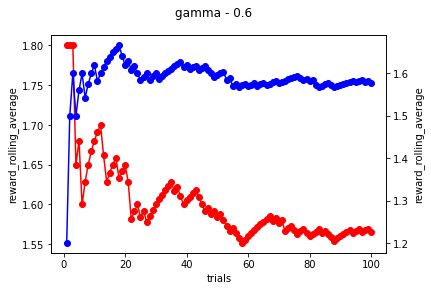

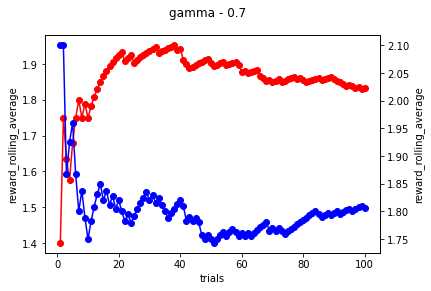

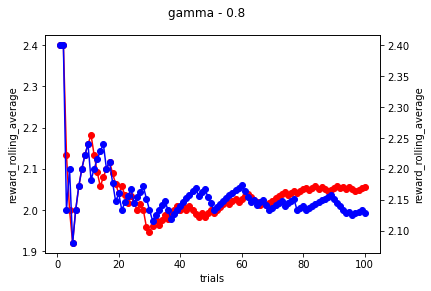

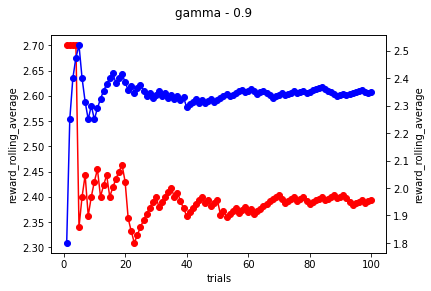

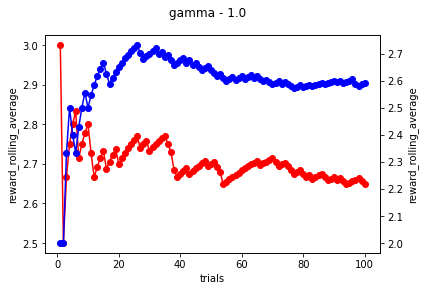

q_rl_rewards [2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 1, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 3, 1, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2]
sarsa_rl_rewards [2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 1, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 1, 2, 3, 2, 2, 2, 3]


q_rl_rewards [3, 1, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 1, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3]
sarsa_rl_rewards [3, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 2

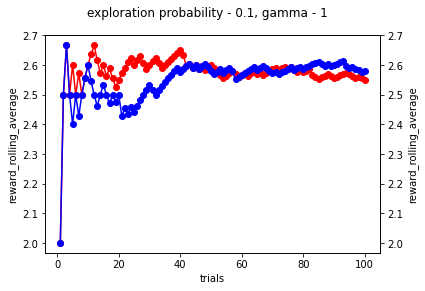

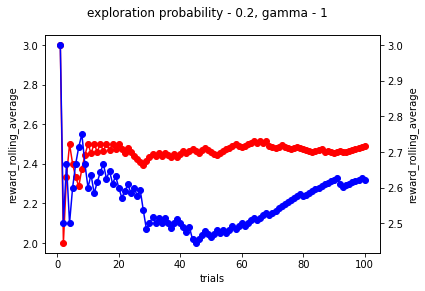

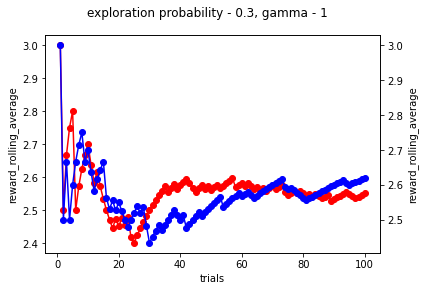

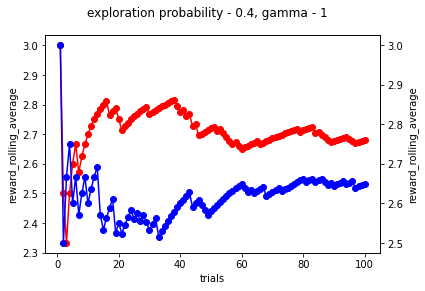

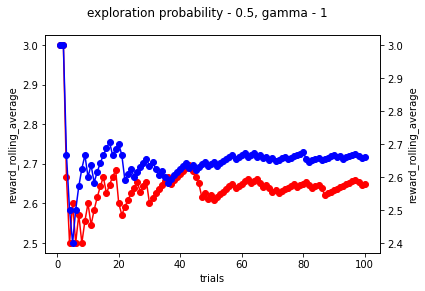

Num total states 51481
ValueIteration: 3 iterations
value_iteration [3.000000000000001, 3.000000000000001, 3.000000000000001]


Num total states 51481
PolicyIteration: 2 iterations
policy_iteration [0, 2.999999999999999, 3.000000000000001]


Num total states 51481
ValueIteration: 3 iterations
value_iteration [3.000000000000001, 3.000000000000001, 3.000000000000001]


Num total states 51481
PolicyIteration: 2 iterations
policy_iteration [0, 3.000000000000001, 3.000000000000001]


Num total states 51481
ValueIteration: 3 iterations
value_iteration [3.000000000000001, 3.000000000000001, 3.000000000000001]


Num total states 51481
PolicyIteration: 2 iterations
policy_iteration [0, 3.000000000000001, 3.000000000000001]


Num total states 51481
ValueIteration: 3 iterations
value_iteration [3.000000000000001, 3.000000000000001, 3.000000000000001]


Num total states 51481
PolicyIteration: 2 iterations
policy_iteration [0, 3.000000000000001, 3.000000000000001]


Num total states 51481
ValueIter

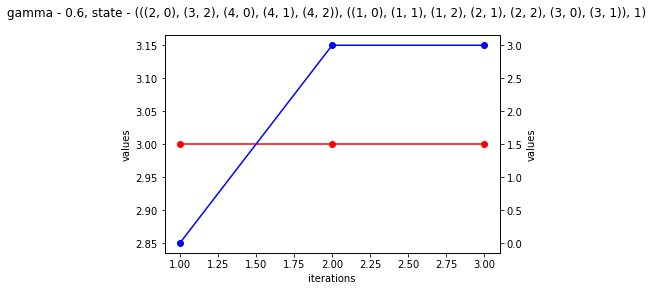

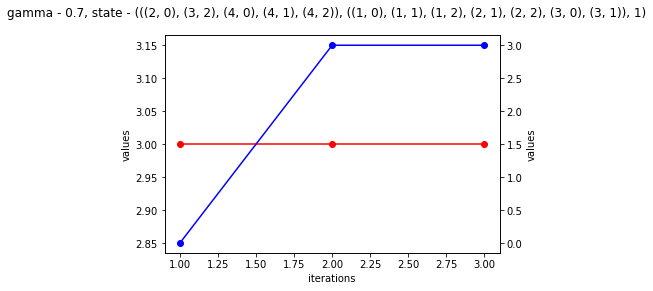

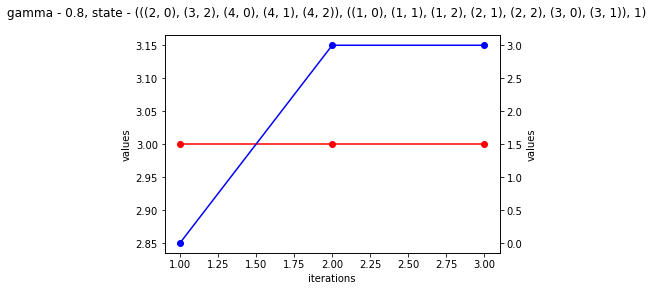

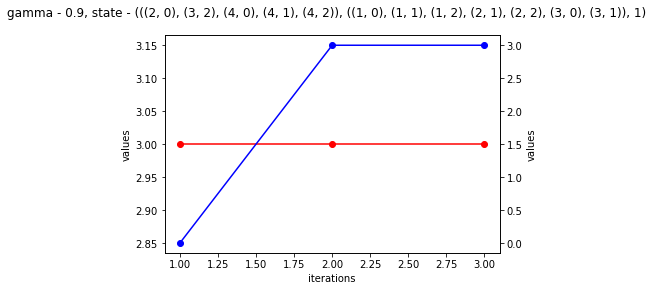

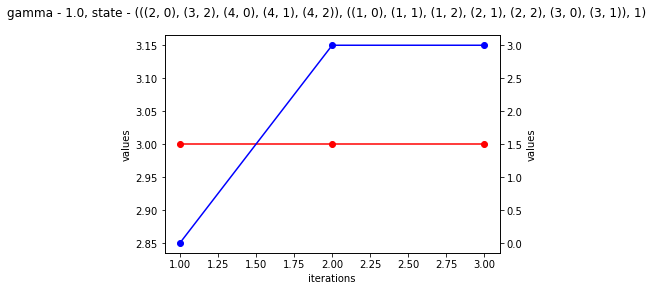

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import arange

# #r = arange(.0001, .0006, .0001)
# r = [.0001, .0005, .010, .1, 2, ]

# alphas = {}
# mdp = PokerMDP([1, 2, 3, 4, 5], 3)

# # For each epsilon, solve the values for all states
# for a in r:
#   alg = ValueIteration()
  
#   print(f'epsilon: {a}')
#   alg.solve(mdp, a)
  
#   # Capture value changes for the state that had the highest value at the end
#   value_changes = alg.value_changes[alg.final_state]
  
#   print('\n')
#   print('state', alg.final_state)
#   print('\n')
  
#   print('value_changes', value_changes)
#   print('\n')
  
#   policy_alg = PolicyIteration()
#   policy_alg.solve(mdp)
  
#   # Capture policy value changes for the state that had the highest value at the end
#   policy_value_changes = policy_alg.value_changes[alg.final_state]
#   print('policy_value_changes', policy_value_changes)
#   print('policy_iteration_pi', policy_alg.pi[alg.final_state])
#   print('\n')

#   q_rl = QLearningAlgorithm(mdp.actions, mdp.discount(), identityFeatureExtractor)
#   q_rl_rewards = simulate(mdp, q_rl, numTrials=num_of_trials)
#   print('q_rl_rewards', q_rl_rewards)

#   sarsa_rl = SARSA(mdp.actions, mdp.discount(), identityFeatureExtractor)
#   sarsa_rl_rewards = simulate(mdp, sarsa_rl, numTrials=num_of_trials)
#   print('sarsa_rl_rewards', sarsa_rl_rewards)
#   print('\n')

#   alphas[a] = {
#       'value_iteration': value_changes,
#       'policy_iteration': policy_value_changes,
#       'q_rl': q_rl_rewards,
#       'sarsa_rl': sarsa_rl_rewards
#   }

#mdp = PokerMDP([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 4)
mdp = PokerMDP([1, 2, 3, 4], 3)
num_of_trials = 100

gamma_dict = {}
gammas = [0.6, 0.7, 0.8, 0.9, 1.0]
for gamma in gammas:
  mdp.setDiscount(gamma)
  q_rl = QLearningAlgorithm(mdp.actions, mdp.discount(), identityFeatureExtractor)
  q_rl_rewards = simulate(mdp, q_rl, numTrials=num_of_trials)

  print('q_rl_rewards', q_rl_rewards)

  sarsa_rl = SARSA(mdp.actions, mdp.discount(), identityFeatureExtractor)
  sarsa_rl_rewards = simulate(mdp, sarsa_rl, numTrials=num_of_trials)
  print('sarsa_rl_rewards', sarsa_rl_rewards)
  print('\n')

  gamma_dict[gamma] = {
      'q_rl': q_rl_rewards,
      'sarsa_rl': sarsa_rl_rewards
  }

def compute_rolling_average(values):
    rolling_averages = []
    sum = 0
    for i in range(0, len(values)):
      sum += values[i]
      rolling_avg = sum /(i + 1)
      rolling_averages.append(rolling_avg)
    return rolling_averages

for gamma, d in gamma_dict.items():
  fig, ax = plt.subplots()
  ax.set_xlabel("trials")
  ax.set_ylabel("reward_rolling_average")
  fig.suptitle(f'gamma - {gamma}')
  
  x_values = list(range(1, num_of_trials + 1))

  q_y_values = compute_rolling_average(d['q_rl'])
  sarsa_y_values = compute_rolling_average(d['sarsa_rl'])
  
  ax.plot(x_values, q_y_values, color="red", marker="o")
  
  ax2 = ax.twinx()
  ax2.set_ylabel("reward_rolling_average")
  ax2.plot(x_values, sarsa_y_values, color="blue", marker="o")

  # Show plot
  plt.show()

discount_for_exploration = 1
mdp.setDiscount(discount_for_exploration)
exploration_probability_dict = {}
exploration_probabilities = [0.1, 0.2, 0.3, 0.4, 0.5]
for exploration_probability in exploration_probabilities:
  q_rl = QLearningAlgorithm(mdp.actions, mdp.discount(), identityFeatureExtractor, explorationProb=exploration_probability)
  q_rl_rewards = simulate(mdp, q_rl, numTrials=num_of_trials)

  print('q_rl_rewards', q_rl_rewards)

  sarsa_rl = SARSA(mdp.actions, mdp.discount(), identityFeatureExtractor, explorationProb=exploration_probability)
  sarsa_rl_rewards = simulate(mdp, sarsa_rl, numTrials=num_of_trials)
  print('sarsa_rl_rewards', sarsa_rl_rewards)
  print('\n')

  exploration_probability_dict[exploration_probability] = {
      'q_rl': q_rl_rewards,
      'sarsa_rl': sarsa_rl_rewards
  }

for exploration_probability, d in exploration_probability_dict.items():
  fig, ax = plt.subplots()
  ax.set_xlabel("trials")
  ax.set_ylabel("reward_rolling_average")
  fig.suptitle(f'exploration probability - {exploration_probability}, gamma - {discount_for_exploration}')
  
  x_values = list(range(1, num_of_trials + 1))

  q_y_values = compute_rolling_average(d['q_rl'])
  sarsa_y_values = compute_rolling_average(d['sarsa_rl'])
  
  ax.plot(x_values, q_y_values, color="red", marker="o")
  
  ax2 = ax.twinx()
  ax2.set_ylabel("reward_rolling_average")
  ax2.plot(x_values, sarsa_y_values, color="blue", marker="o")

  # Show plot
  plt.show()

gamma_dict = {}
final_state = None
for gamma in gammas:
  mdp.setDiscount(gamma)
  value_iteration = ValueIteration()
  value_iteration.solve(mdp)
  value_changes = value_iteration.value_changes[value_iteration.final_state]
  print('value_iteration', value_changes)
  print('\n')

  # Track the final state that gave the largest change in value for the last iteration in ValueIteration.
  # Track the value changes for this same state in PolicyIteration.
  # TODO: Is this how we want to track the value changes to plot? Unsure.
  if final_state is None:
    final_state = value_iteration.final_state

  policy_iteration = PolicyIteration()
  policy_iteration.solve(mdp)
  
  # Capture policy value changes for the state that had the highest value at the end
  policy_value_changes = policy_iteration.value_changes[value_iteration.final_state]
  print('policy_iteration', policy_value_changes)
  print('\n')

  gamma_dict[gamma] = {
      'value_iteration': value_changes,
      'policy_iteration': policy_value_changes
  }

for gamma, d in gamma_dict.items():
  fig, ax = plt.subplots()
  ax.set_xlabel("iterations")
  ax.set_ylabel("values")
  fig.suptitle(f'gamma - {gamma}, state - {final_state}')
  
  x_length = len(d['value_iteration']) if len(d['value_iteration']) > len(d['policy_iteration']) else len(d['policy_iteration'])
  x_values = list(range(1, x_length + 1))

  value_iteration_diff = abs(x_length - len(d['value_iteration']))
  policy_iteration_diff = abs(x_length - len(d['policy_iteration']))
  
  for _ in range(0, value_iteration_diff):
    d['value_iteration'].append(d['value_iteration'][-1])

  for _ in range(0, policy_iteration_diff):
    d['policy_iteration'].append(d['policy_iteration'][-1])

  value_iteration_values = d['value_iteration']
  policy_iteration_values = d['policy_iteration']
  
  ax.plot(x_values, value_iteration_values, color="red", marker="o")
  
  ax2 = ax.twinx()
  ax2.set_ylabel("values")
  ax2.plot(x_values, policy_iteration_values, color="blue", marker="o")

  # Show plot
  plt.show()

# x_values = list(range(1, len(value_changes) + 1))
# ax.plot(x_values, value_changes, marker="o")
# ax.set_xlabel("iterations")
# ax.set_ylabel("value")
# ax.legend(str(a))

# # Creating y axis clones for plotting new trendlines
# for label, value_changes in plot_datas[1:]:
#   ax2 = ax.twinx()
#   x_values = list(range(1, len(value_changes) + 1))
#   ax2.plot(x_values, value_changes, marker="o")
#   ax2.set_ylabel("value")
#   ax2.legend(str(label))

# # Show plot
# plt.show()